# Footprint removal via k-k filtering

Matteo Niccoli provided key suggestions and code related to the filtering.

demo seismic data (F3_original_subvolume_IL230-430_XL475-675_T200-1800.npy) can be downloaded from: https://drive.google.com/file/d/1z27fmb3EM9rCLUVIHGTjFiFXyDRZnsln/view?usp=sharing

### Set up the workspace:

In [1]:
import numpy as np
import scipy as sp
from scipy import ndimage as ndi
from numpy.fft import fft2, ifft2, fftshift, ifftshift

from skimage import io
from skimage.util import img_as_float
from skimage.filters import gaussian
from skimage.color import rgb2gray, label2rgb
from skimage.feature import peak_local_max, canny
from skimage.restoration import denoise_tv_chambolle
from skimage.draw import  circle
import skimage.morphology as morph
from skimage.measure import label, compare_ssim
import skimage.exposure as skie
from astropy.convolution import convolve, Gaussian2DKernel
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, interact_manual, FloatSlider, IntSlider, fixed
import ipywidgets as widgets
from IPython.display import display
import matplotlib.patches as patches

# ONCE FUNCTIONS ARE PRUNED BACK, REVISIT THIS LIST OF LIBRARIES #

Defining a number of functions here:

In [2]:
def numpy_fft2(im):
    F = np.fft.fft2(im)     # Perform 2-dimensional discrete Fourier transform 
    C = np.fft.fftshift(F)  # Center spectrum on minimum frequency
    Mag = np.abs(C).real    # Get magnitude and phase
    Ph  = np.angle(C).real    
    return Mag, Ph


def im_pad(im):
    out = np.zeros([3*im.shape[0],3*im.shape[1]])
    out[im.shape[0]:2*im.shape[0],im.shape[1]:2*im.shape[1]]=im
    return out

def im_unpad(im):
    out = im[im.shape[0]//3:2*im.shape[0]//3,im.shape[1]//3:2*im.shape[1]//3]
    return out



def reverse_padding(im, filtered_im, slc):
    m, n = np.shape(im) # get input shape
     
    if m > n:
        print("Unpadding image columns")
        return filtered_im[:, slc]       
    else:
        print("Unpadding image rows")
        return filtered_im[slc, :]      

In [3]:
# Mycarta's image pad function, was updated from original:

def pad_next_square_size(im):
    """Function to pad a rectangualr image to a square image.
    Parameters:
    im (2D array): input grayscale image
    
    Returns:
    out (2D array): padded input image
    padding (slice object): a slice object that can be used later on to unpad
    
    Example:
    out, padding = pad_next_square_size(im)
    """
    m, n = np.shape(im) # get input shape
    deficit = max([m,n])- min([m,n])  # get deficit between size lengths

    # difference in dimensions is even, pad both sides of short dimension by deficit//2
    if deficit%2 == 0: 
        deficit1 = deficit//2
        deficit2 = deficit//2
    
    # difference in dimensions is odd, pad one side by deficit//2 +1
    else:
        deficit1 = deficit//2
        deficit2 = deficit1+1
        
    if m > n:
        print("Padded image columns")
        return (np.pad(im,((0,0), (deficit1,deficit2)), 'reflect'), slice(deficit1, -deficit2))
        
    else:
        print("Padded image rows")
        return (np.pad(im,((deficit1,deficit2), (0,0)), 'reflect'), slice(deficit1, -deficit2))
        

In [4]:
# EG's padding built on MyCarta's previous padding algo. Now it's redundant, but utilized by _next_pow2.
# Really should prune back to a single padding function...

def pad_to_square(im):
    m, n = np.shape(im) # get input shape    
    deficit = max([m,n])- min([m,n])  # get deficit between size lengths

    # check if odd since we want to pad on either side of short size by deficit/2
    if deficit%2 == 0: 
        deficit1 = int((deficit - deficit%2)/2)
        deficit2 = int(deficit1) # fixed error in this line
    else:
        deficit1 = int((deficit - deficit%2)/2)
        deficit2 = int(deficit1 +1)
        
    if m > n:
        #print("Padded image columns")
        return (np.pad(im,((0,0), (deficit1,deficit2)), 'reflect'), deficit1, deficit2)
        
    else:
        #print("Padded image rows")
        return (np.pad(im,((deficit1,deficit2), (0,0)), 'reflect'), deficit1, deficit2)
    
def eg_pad_next_pow2(im):
    m, n = np.shape(im) # get input shape
    
    if m > n:
        # find next power of 2 for long side. Let's add a 20% buffer to ensure some pad is added.
        target_length = 1<<(int(1.2*m)-1).bit_length()
        
        deficit_m = target_length - m  # get deficit between size lengths
        
        # check if odd since we want to pad on either side of short size by deficit/2
        if deficit_m%2 == 0: 
            deficit_m1 = int((deficit_m - deficit_m%2)/2)
            deficit_m2 = int(deficit_m1) # fixed error in this line
        else:
            deficit_m1 = int((deficit_m - deficit_m%2)/2)
            deficit_m2 = int(deficit_m1 +1)
            
        im_out = np.pad(im,((deficit_m1,deficit_m2),(0,0)), 'reflect')
        
        im_out, deficit_n1, deficit_n2 = pad_to_square(im_out)
        
    else:
        # find next power of 2 for long side. Let's add a 20% buffer to ensure some pad is added.
        target_length = 1<<(int(1.2*n)-1).bit_length()
        
        deficit_n = target_length - n  # get deficit between size lengths
        
        # check if odd since we want to pad on either side of short size by deficit/2
        if deficit_n%2 == 0: 
            deficit_n1 = int((deficit_n - deficit_n%2)/2)
            deficit_n2 = int(deficit_n1) # fixed error in this line
        else:
            deficit_n1 = int((deficit_n - deficit_n%2)/2)
            deficit_n2 = int(deficit_n1 +1)
            
        im_out = np.pad(im,((0,0),(deficit_n1,deficit_n2)), 'reflect')
        
        im_out, deficit_m1, deficit_m2 = pad_to_square(im_out)
        
    return im_out

def eg_unpad_next_pow2(im_pad, im):
    m, n = np.shape(im) # get input shape
    
    # First, use the eg_unpad_next_pow2 algo to find deficit_m1, _m2, _n1, _n2.
    if m > n:
        # find next power of 2 for long side. Let's add a 20% buffer to ensure some pad is added.
        target_length = 1<<(int(1.2*m)-1).bit_length()
        
        deficit_m = target_length - m  # get deficit between size lengths
        
        # check if odd since we want to pad on either side of short size by deficit/2
        if deficit_m%2 == 0: 
            deficit_m1 = int((deficit_m - deficit_m%2)/2)
            deficit_m2 = int(deficit_m1) # fixed error in this line
        else:
            deficit_m1 = int((deficit_m - deficit_m%2)/2)
            deficit_m2 = int(deficit_m1 +1)
            
        im_out = np.pad(im,((deficit_m1,deficit_m2),(0,0)), 'reflect')
        
        im_out, deficit_n1, deficit_n2 = pad_to_square(im_out)
        
    else:
        # find next power of 2 for long side. Let's add a 20% buffer to ensure some pad is added.
        target_length = 1<<(int(1.2*n)-1).bit_length()
        
        deficit_n = target_length - n  # get deficit between size lengths
        
        # check if odd since we want to pad on either side of short size by deficit/2
        if deficit_n%2 == 0: 
            deficit_n1 = int((deficit_n - deficit_n%2)/2)
            deficit_n2 = int(deficit_n1) # fixed error in this line
        else:
            deficit_n1 = int((deficit_n - deficit_n%2)/2)
            deficit_n2 = int(deficit_n1 +1)
            
        im_interim = np.pad(im,((0,0),(deficit_n1,deficit_n2)), 'reflect')
        
        im_interim, deficit_m1, deficit_m2 = pad_to_square(im_interim)
        
    
    # Now that deficit_m1, _m2, _n1, _n2 are known, extract the original image from the padded one. 
    im_out = im_pad[deficit_m1:-deficit_m2, deficit_n1:-deficit_n2]
        
    return im_out

In [5]:
def sum_interval(volume, zslice, zwindow):
    """
    sum_interval retrieves a number of time slices from a volume,
    calculates the sum of slices.
        
    volume = 3D volume
    zslice = slice index for which sum is to 
            be calculated
    zwindow = the number slices to be considered. An equal number
            of slices above and below target slice are considered.
            
    returns a 2d slice
    """
        
    for zed in range(zslice-zwindow//2, zslice+zwindow//2 + 1):
        if zed >= 0 and zed < volume.shape[2]:
            interim = volume[:,:,zed]
            if 'stack' not in locals():
                stack = np.expand_dims(interim, axis=2)
            else:
                stack = np.concatenate((stack, np.expand_dims(interim, axis=2)), axis=2)
      
    out = np.sum(stack, axis=2)
    
    return out

In [6]:
"""
These were created to ensure to maxima were picked near the center of the spectra,
where the peaks were likely to be caused by geology and not footprint.

blank_spec_center and blank_spec_outer are designed to be applied to a spectrum. This
could be useful for figure generation.

center_max_coord_remove is applied to a list of coordinates and removes those that
are near the center of the spectrum. This approach was replaced by center_max_remove,
so it's not useful now.

center_max_remove is applied to the array-style (as opposed to coordinate style) of
spectrum maxima. It removes those maxima near the center.
"""


def blank_spec_center(spec,pct=5):
    """
    Remove the center portion from a 2d fft. A square of the spectrum
    with length (pct = the percent of the spectrum) to remove as a
    function of the spectrum size. Assumes spec is a sqaure.
    """
    haxis = spec.shape[0]//2
    bl_side = int(haxis*pct/100)
    out = spec[:]
    out[haxis-bl_side:haxis+bl_side,haxis-bl_side:haxis+bl_side] = 0
    return out

def blank_spec_outer(spec,pct=50):
    """
    Remove the outer portion from a 2d fft. A square of the spectrum
    with length (pct = the percent of the spectrum) to remove as a
    function of the spectrum size. Assumes spec is a sqaure.
    """
    haxis = spec.shape[0]//2
    bl_side = int(haxis*pct/100)
    out = np.zeros_like(spec)
    out[bl_side:-bl_side,bl_side:-bl_side] = spec[bl_side:-bl_side,bl_side:-bl_side]
    return out

def center_max_remove(fft_maxima, pct=5):
    """
    Remove maxima selected in the center portion of a 2d fft.
    A square of the spectrum with length (pct = the percent of the spectrum) to remove as a
    function of the spectrum size. Assumes spec is a sqaure.
    """
    haxis = fft_maxima.shape[0]//2
    bl_side = int(haxis*pct/100)
    out = fft_maxima[:]
    out[haxis-bl_side:-(haxis-bl_side),haxis-bl_side:-(haxis-bl_side)] = 0
    return out

def center_max_coord_remove(spectrum, coordinates, pct=5):
    """
    This function is used to remove the maxima when defined by coordinates.
    
    The production version of the algorithm uses an array-based function instead.
    
    Remove maxima selected in the center portion of a 2d fft.
    A square of the spectrum with length (pct = the percent of the spectrum) to remove as a
    function of the spectrum size. Assumes spec is a sqaure.
    """
    haxis = spectrum.shape[0]//2
    pass_side = int(haxis*(100-pct)/100)
    
    coord_out = []
    for coord in coordinates:
        if not(pass_side < coord[0]  and coord[0] < (spectrum.shape[0]-pass_side)
               and pass_side < coord[1]  and coord[1] <= (spectrum.shape[0]-pass_side) ):                
            coord_out.append(coord)
    
    return np.array(coord_out)

### Load some test data:

In [7]:
#The data file used for algo development
devfile = "F3_original_subvolume_IL230-430_XL475-675_T200-1800.npy"

#Load it
data = np.load(devfile)

print("Data shape:" + str(data.shape))

Data shape:(201, 201, 401)


The file name gives us a hint about the data... 201 ILs, 201 XLs, 401 time steps of 4 ms.

Let's have a look:

Text(0, 0.5, 'xline')

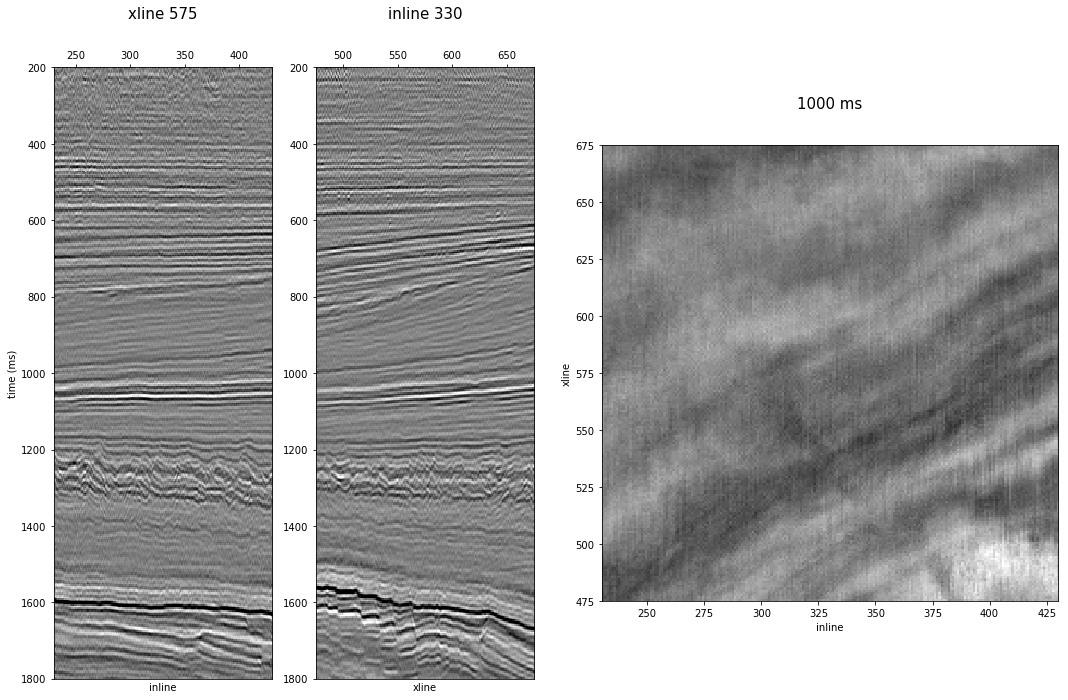

In [8]:
# find 99th percentile of amplitude for plot scaling
plotamp = np.percentile(data, 99.9)

# Plot the 3D data
atts = plt.figure(figsize=(18,12))

# Look at XL index 100
ax1 = atts.add_subplot(141)
ax1.imshow(data[:,100,:1000].T,extent=(230,430,1800,200), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='0.35')
ax1.xaxis.tick_top()
plt.text(0.5, 1.08, 'xline 575', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('inline')
ax1.set_ylabel('time (ms)')
#ax1.axes.get_yaxis().set_ticks(times[::50])

# Look at IL index 100
ax1 = atts.add_subplot(142)
ax1.imshow(data[100,:,:1000].T,extent=(475,675,1800,200), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='0.35')
ax1.xaxis.tick_top()
plt.text(0.5, 1.08, 'inline 330', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('xline')
#ax1.set_ylabel('time (ms)')
#ax1.axes.get_yaxis().set_ticks([])

# Look at T index 200
ax1 = atts.add_subplot(122)
ax1.imshow(data[:,:,200].T, extent=(230, 430, 475, 675), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='1') # I didn't plot the Transpose here
plt.text(0.5, 1.08, '1000 ms', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('inline')
ax1.set_ylabel('xline')

Okay. This looks alright.

In [9]:
# generate an array that is a stack of fft2 of the data
data_fft2 = np.zeros((eg_pad_next_pow2(data[:,:,0]).shape[0], eg_pad_next_pow2(data[:,:,0]).shape[1], data.shape[2]))

for z in range(data.shape[2]):
    data_fft2[:,:,z] = numpy_fft2(eg_pad_next_pow2(data[:,:,z]))[0]
    
# CONSIDER ADDING A PROGRESS BAR #

## The widget

The widget will help select the parameter values for a dataset.

The input for the widget is stack of 2D fft slices from a 3D numpy array. For efficiency, it's best if this is a representative sub-volume of the seismic data: covers enough area to show a pattern of acquisiton footprint.

The spectra are used by the widget to calculate and apply filters.

What parameters do we need to specify?

* aslice
* number of slices to stack
* number of spectral peaks to identify
* denoise (y/n) (perhaps not necesarry? weight = 0 would be no filtering?)
* denoise weight
* minimum distance between peaks (necesarry? define as percentage of spectra size?)
* example section (with IL/XL) (maybe just use the center IL?)
* Gaussian kernal width (necesarry? define as percentage of spectra size?)
* central spectra pass (%)
* spectral filter strength (necesarry? I think so, but maybe we can set this parameter?)
* anything else???


First thing first... need a function (or tree of functions) to perform all the steps, including figure generation. Which figures?

* seismic section with time slice indicated (optional?) (right side, line 2 and 3))

* single slice spectrum (optional) (center, second line)
* stacked spectrum with denoise (right, second line)
* stacked spectra with peaks (center, third line) (but could the peaks be indicated by open circles instead of points? could we also show the center spectra pass? It would allow this figure to be merged with the stacked, denoised spectrum

* illustration of gaussian kernal (optional?) (third line?)

* original timeslice vs final timeslice with difference (top line)





In [10]:
def fs_parameterize(seismic, spectra_stack, aslice, num_slices, denoise_weight, num_peaks,
                    min_peak_dist, center_spec_pass, gauss_kernal_width, filt_strength):
    
    """
    seismic  = seismic volume used for footprint filter parameterization.
    spectra_stack = stack of 2D amplitude spectra for each timeslice of seismic
    aslice = the example slice used for analysis
    num_slices = the number of slices stacked to suppress spectrum noise
    denoise_weight = weight parameter of denoise_tv_chambolle filter applied to stacked spectra
    num_peaks = number of peaks automatically picked on spectra
    min_peak_dist = minimum distance between peaks picked on specrta (defined as pixels?)
    center_spec_pass = peaks within this distance of spectrum center are ignored (defined as percentage)
    gauss_kernal_width = the width of the gaussian kernal convlved with spectrum peak coordinates.
    filt_strength = defines the filter strength. Usually around 1 or 2.
    
    
    """
    
    
    # Prepare the spectrum
    
    # Denoise the spectrum by stacking adjacent spectra
    stacked_spec = sum_interval(spectra_stack, aslice, num_slices)
    # Denoise the spectrum using a filter
    stacked_filt_spec = denoise_tv_chambolle(np.log(stacked_spec+1), weight=denoise_weight)
    
    
    # Find the peaks
    
    # Filtering array - pick the peaks
    peak_array = peak_local_max(stacked_filt_spec, min_distance=min_peak_dist, num_peaks=num_peaks, indices = False)
    # Filtering array - remove central peaks
    peak_array_center_removed = center_max_remove(peak_array, pct=center_spec_pass)
    # Illustration - pick the peaks
    peak_coordinates = peak_local_max(peak_array_center_removed)#, min_distance=min_peak_dist, num_peaks=num_peaks)
    
    
    # Create the spectral filter
    
    # Define a filter kernal:
    gauss_ker = Gaussian2DKernel(gauss_kernal_width)
    # Convolve peaks with the gaussian kernal
    spec_filter = convolve(peak_array_center_removed, gauss_ker)
    
    
    # Apply the filter
    
    # Calculate filter strength
    spec_filter_strength = 1/np.max(gauss_ker.array)*filt_strength
    # Filter a slice
    aslice_filtered = eg_unpad_next_pow2(ifft2(np.multiply(ifftshift(1-spec_filter_strength * spec_filter),fft2(eg_pad_next_pow2(seismic[:,:,aslice])))).real, seismic[:,:,aslice])
    
    
    
    # Generate the figures
    
    fig = plt.figure(figsize=(16,16))
    
    # Seismic section with timeslice indicated
    il = seismic.shape[0]//2 # find the center IL
    plotamp = np.percentile(seismic[il,:,:], 99.9)
    ax1 = plt.subplot2grid((5,3), (4,0), colspan=3, rowspan=1)
    plt.imshow(seismic[il,:,:].T, interpolation='none', cmap='gray', aspect=1, vmin=-plotamp, vmax=plotamp)
    
    # Original timeslice
    ax2 = plt.subplot2grid((5,3), (0,0), colspan=1, rowspan=2)
    plt.imshow(seismic[:,:,aslice], interpolation='none', cmap='gray', aspect=1, vmin=-plotamp, vmax=plotamp)
    
    # Filtered timeslice
    ax3 = plt.subplot2grid((5,3), (0,1), colspan=1, rowspan=2)
    plt.imshow(aslice_filtered, interpolation='none', cmap='gray', aspect=1, vmin=-plotamp, vmax=plotamp)
    
    # Footprint removed
    ax4 = plt.subplot2grid((5,3), (0,2), colspan=1, rowspan=2)
    plt.imshow(seismic[:,:,aslice]-aslice_filtered, interpolation='none', cmap='gray', aspect=1, vmin=-plotamp, vmax=plotamp)
    
    # Original spectrum
    ax5 = plt.subplot2grid((5,3), (2,0), colspan=1, rowspan=2)
    plt.imshow(np.log(spectra_stack[:,:,aslice]), interpolation='none', cmap='gray', aspect=1)
    
    # Stacked and denoised spectrum...
    ax6 = plt.subplot2grid((5,3), (2,1), colspan=1, rowspan=2)
    plt.imshow(np.log(stacked_filt_spec), interpolation='none', cmap='gray', aspect=1)
    # ...with peaks...
    plt.scatter(peak_coordinates[:, 1], peak_coordinates[:, 0],s=50, edgecolors='m', facecolors='none')
    #...and central pass...
    halfaxis = stacked_filt_spec.shape[0]//2 # we're assuming a square spectrum
    bl_side = int(halfaxis*center_spec_pass/100)
    rect = patches.Rectangle((halfaxis-bl_side, halfaxis-bl_side), 2*bl_side, 2*bl_side, linewidth=1, edgecolor='g', facecolor='none')
    ax6.add_patch(rect)
    
    # Filter spectrum
    ax7 = plt.subplot2grid((5,3), (2,2), colspan=1, rowspan=2)
    plt.imshow(spec_filter, interpolation='none', cmap='gray', aspect=1)

    plt.show()
    
    

/Users/Galloway/opt/anaconda3/envs/seis-process/lib/python3.5/site-packages/skimage/restoration/_denoise.py:226: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  g[slices_g] = np.diff(out, axis=ax)
/Users/Galloway/opt/anaconda3/envs/seis-process/lib/python3.5/site-packages/skimage/restoration/_denoise.py:212: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  d[slices_d] += p[slices_p]


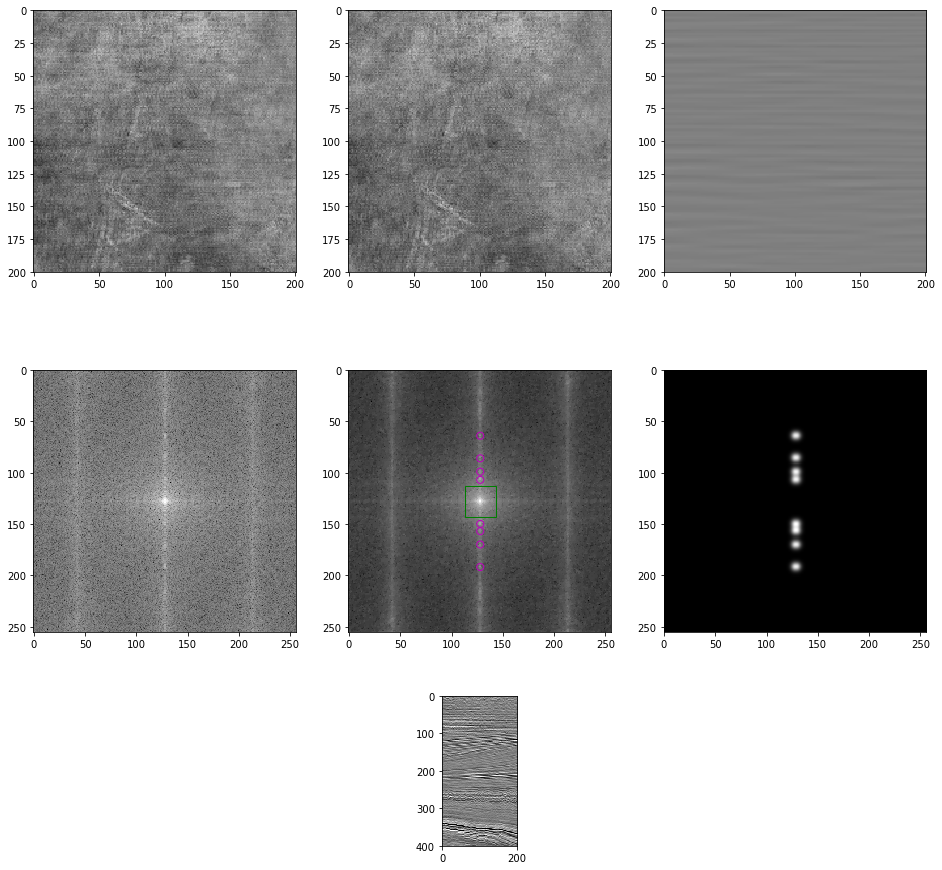

In [11]:
fs_parameterize(data, data_fft2, aslice=50, num_slices=5, denoise_weight=0.1, num_peaks=9,
                    min_peak_dist=5, center_spec_pass=12, gauss_kernal_width=3, filt_strength=0.8)

In [12]:
rslt = interactive(fs_parameterize, seismic=fixed(data), spectra_stack=fixed(data_fft2),                   
                   aslice=IntSlider(min=0, max=data.shape[2], step=1, value = 50, continuous_update=False),
                   num_slices=IntSlider(min=1, max=20, step=1,value=10),
                  denoise_weight=FloatSlider(min=0.1, max=1, step=0.1,value=0.2),
                  num_peaks=IntSlider(min=3, max=29, step=1,value=9),
                  min_peak_dist=IntSlider(min=1, max=50, step=1,value=5),
                  center_spec_pass=FloatSlider(min=1, max=25, step=1,value=5),
                  gauss_kernal_width=IntSlider(min=1, max=25, step=1,value=5),
                  filt_strength=FloatSlider(min=0.1, max=3, step=0.1,value=1))

In [13]:
display(rslt)

interactive(children=(IntSlider(value=50, continuous_update=False, description='aslice', max=401), IntSlider(v…

In [17]:
style={'description_width': 'initial'}

rslt_manual = interact_manual(fs_parameterize, seismic=fixed(data), spectra_stack=fixed(data_fft2),                   
                   aslice=IntSlider(description='Example Slice', min=0, max=data.shape[2], step=1, value = 50, continuous_update=False, style=style),
                   num_slices=IntSlider(description='Slices Stacked', min=1, max=20, step=1,value=10, style=style),
                  denoise_weight=FloatSlider(description='Denoise Weight', min=0.1, max=1, step=0.1,value=0.2, style=style),
                  num_peaks=IntSlider(description='Peaks to Pick', min=3, max=29, step=1,value=9, style=style),
                  min_peak_dist=IntSlider(description='Min Peak Distance', min=1, max=50, step=1,value=5, style=style),
                  center_spec_pass=FloatSlider(description='Center Pass Width', min=1, max=25, step=1,value=5, style=style),
                  gauss_kernal_width=IntSlider(description='Kernel Width', min=1, max=25, step=1,value=5, style=style),
                  filt_strength=FloatSlider(description='Filter Strength', min=0.1, max=3, step=0.1,value=1, style=style))

interactive(children=(IntSlider(value=50, continuous_update=False, description='Example Slice', max=401, style…

Check this out for tips on formatting the widgets:

https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
